# Introduction to Artificial Intelligence 
## CNN Classifier Training Notebook

## Benjamin Frost & Sophie Chalklin 
#### December 2020

This notebook uses training data generated by the notebook 'HandRecognition.ipynb' to train a CNN image classifier.
This classifier is then loaded back in to the 'HandRecognition.ipynb' to be able to classify images in real time.

#### Prerequisites

##### Libraries

This notebook was developed with the following library versions:

opencv-contrib-python==4.4.0.46<br />
numpy==1.19.3<br />
Keras==2.4.3<br />
tqdm==4.54.1<br />
matplotlib==3.3.2<br />
scikit-image==0.17.2<br />
scikit-learn==0.23.2<br />
tensorflow-gpu==2.4.0<br />
imutils==0.5.3<br />
seaborn==0.11.0

##### Model

In order for this notebook to load in the data required for classification, the images must be placed in the folders "HandsData/One" and "HandsData/None" relative to this notebook.

In [74]:
import os
import cv2
import numpy as np
import keras
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import imutils
import io
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.utils
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

In [75]:
categories = ["One", "None"]
dataDirectory = "HandsData/"

sizeX = 60
sizeY = 100

In [76]:
def resize(image):
    
    # Since size of the box around the hand can vary each frame by a great deal, 
    # this function ensures that image sizes are standardised to 60 by 100.
    # This is important since the classifier needs all input images to be the same size.
    
    
    # Converting from the old BGR to RGB
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    h, w, ch = image.shape
    
    
    #Creating the base of the new standardised image
    
    zeros = np.zeros((sizeY, sizeX, 3))
    
    tempImage = image.copy()
    
    
    # Resize the image to be just as tall as the standardised dimensions.
    
    image = imutils.resize(tempImage, height=sizeY)
    
    
    # If this resizing process results in an image that has a width greater than 60,
    # instead resize the image to be just as wide as the standardised dimensions.
    
    if image.shape[1] > sizeX:
        image = imutils.resize(tempImage, width=sizeX)
    
    # One of these resizing options will result in an image that either has a black 
    # portion at the top or at the right hand side.
    
    zeros[:image.shape[0], :image.shape[1]] = image
    
    return zeros

In [77]:
X = []
y = []

# This loop loads in the data required for classification. Although we decided to proceed
# with just two classes, it could be easily scaled to support more.

for category in categories:
    
    path = dataDirectory + category + "/Combined"
    
    # TQDM gives a helpful progress bar to see how quickly the data is being loaded.
    # We load in every second image since the dataset is quite large and the images were
    # taken from a video so can be similar to each other.
    
    for image in tqdm(os.listdir(path)[::2]):
        
        image = cv2.imread(path + '/' + image)
        
        image = resize(image)
        
        X.append(image)
        y.append(categories.index(category))
        

100%|█████████████████████████████████████████████████████████████████████████████| 1514/1514 [00:08<00:00, 169.44it/s]


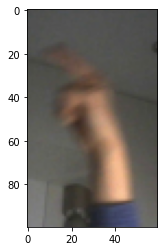

In [78]:
# We can see the black bar on this image as mentioned in the resize() method.
# Images will either have this bar as seen here on the right, or at the top.
# This ensures all images are 60 x 100.

plt.imshow(X[170].astype(np.uint8))
plt.show()

In [79]:
X = np.array(X)

y = tf.keras.utils.to_categorical(np.asarray(y))

# Visualising the data

print(X.shape)
print(y)

X = X.reshape(-1, sizeX, sizeY, 3)

(3116, 100, 60, 3)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [80]:
# Splitting the data into train and test, with 30% reserved for testing.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31)

print(y_train)
print(X_train[0][0][:5])

[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]
[[82. 83. 77.]
 [82. 83. 77.]
 [83. 83. 80.]
 [84. 84. 84.]
 [84. 84. 84.]]


(60, 100, 3)


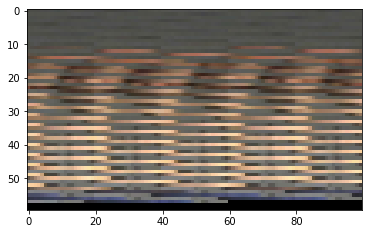

In [81]:
print(X_test[0].shape)

# It's interesting to visualise here how the images have been affected by the reshaping operation performed above.

plt.imshow(X_test[0].astype(np.uint8))
plt.show()

In [82]:
# Creating our model

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=X.shape[1:]))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=128, activation='relu'))

# Since we are creating a binary classifier sigmoid is the mode appropriate activation function.
model.add(Dense(units=2, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 58, 98, 16)        448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 29, 49, 16)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 29, 49, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 27, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 13, 23, 32)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 13, 23, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 11, 21, 64)       

In [83]:
print(X_train.shape)
print(y_train.shape)

(2181, 60, 100, 3)
(2181, 2)


In [84]:
# Data Augmentation

# Since many of the training images look the same, data augmentation is implemented to 
# alter the dataset randomly and reduce overfitting.
# This process replaces our old dataset with the new augmented dataset.

aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

train_aug = aug.flow(X_train, y_train, batch_size=4)


In [ ]:
history = model.fit(train_aug, verbose=2, epochs=100)

Epoch 1/100
546/546 - 9s - loss: 1.8188 - accuracy: 0.5988
Epoch 2/100
546/546 - 8s - loss: 0.6558 - accuracy: 0.6410
Epoch 3/100
546/546 - 9s - loss: 0.6532 - accuracy: 0.6337
Epoch 4/100
546/546 - 9s - loss: 0.6428 - accuracy: 0.6538
Epoch 5/100
546/546 - 9s - loss: 0.6389 - accuracy: 0.6529
Epoch 6/100
546/546 - 9s - loss: 0.6366 - accuracy: 0.6630
Epoch 7/100
546/546 - 9s - loss: 0.6323 - accuracy: 0.6680
Epoch 8/100
546/546 - 10s - loss: 0.6407 - accuracy: 0.6506
Epoch 9/100
546/546 - 10s - loss: 0.6301 - accuracy: 0.6612
Epoch 10/100
546/546 - 9s - loss: 0.6255 - accuracy: 0.6566
Epoch 11/100
546/546 - 9s - loss: 0.6139 - accuracy: 0.6703
Epoch 12/100
546/546 - 10s - loss: 0.6019 - accuracy: 0.6845
Epoch 13/100
546/546 - 10s - loss: 0.6069 - accuracy: 0.6722
Epoch 14/100
546/546 - 11s - loss: 0.6152 - accuracy: 0.6644
Epoch 15/100
546/546 - 10s - loss: 0.6129 - accuracy: 0.6722
Epoch 16/100
546/546 - 10s - loss: 0.5883 - accuracy: 0.6919
Epoch 17/100
546/546 - 11s - loss: 0.6146 

In [ ]:
# This section saves each model for future reference

version = 1
modelDir = "Model Versions/HandModelV"

while True:
    try:
        f = open(modelDir + str(version) + ".h5", 'r')
        f.close()
        version = version + 1
    except:
        break
    
model.save(modelDir + str(version) + ".h5")

In [ ]:
# Testing our model

pred_hot = model.predict(X_test)

# Getting the most likely classification from the output

pred = np.argmax(pred_hot, axis=1)

y_compare = np.argmax(y_test, axis=1)

score = metrics.accuracy_score(y_compare, pred)

# Printing the score of the model on the test set

print("Accuracy score: {}".format(score))

In [ ]:
# Plotting the loss function of our model - the prediction error of the network.

plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch Number')
plt.show()

In [ ]:
# Plotting the accuracy of the model against the test set at each epoch.

plt.plot(history.history['accuracy'])
plt.title('Hand Recognition Accuracy')
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# Plotting the confusion matrix of true positives and false positives etc.

mat = confusion_matrix(pred, y_compare)

sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.show()